In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [45]:
# 导入训练集数据
monster = pd.read_csv("..//input/train.csv")

# 输出统计信息
print(monster.describe())
print("------")
print(monster.info())
print("------")
print(monster.head())

               id  bone_length  rotting_flesh  hair_length    has_soul
count  371.000000   371.000000     371.000000   371.000000  371.000000
mean   443.676550     0.434160       0.506848     0.529114    0.471392
std    263.222489     0.132833       0.146358     0.169902    0.176129
min      0.000000     0.061032       0.095687     0.134600    0.009402
25%    205.500000     0.340006       0.414812     0.407428    0.348002
50%    458.000000     0.434891       0.501552     0.538642    0.466372
75%    678.500000     0.517223       0.603977     0.647244    0.600610
max    897.000000     0.817001       0.932466     1.000000    0.935721
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-

In [46]:
# 类型转换为序列号
color_label = LabelEncoder()
monster['color'] = color_label.fit(monster['color']).transform(monster['color'])

type_label = LabelEncoder()
monster['type'] = type_label.fit(monster['type']).transform(monster['type'])

In [47]:
class Ensemble(object):
    def __init__(self, n_folds, base_models, stacker):
        self.n_folds = n_folds
        self.base_models = base_models
        self.stacker = stacker
        
    def predict(self, X):
        test = np.zeros((X.shape[0], len(self.base_models)))
        
        for i , clf in enumerate(self.base_models):
            test[:, i] = clf.predict(X)
            
        return self.stacker.predict(test)
    
    def fit_predict(self, train_X, train_y, test_X):
        train_X = np.array(train_X)
        train_y = np.array(train_y)
        test_X = np.array(test_X)
        
        folds = list(KFold(len(train_y), n_folds = self.n_folds, shuffle=True, random_state=2016))
        
        S_train = np.zeros((train_X.shape[0], len(self.base_models)))
        S_test = np.zeros((test_X.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((test_X.shape[0], len(folds)))
            
            for j, (train_idx, cv_idx) in enumerate(folds):
                X_train = train_X[train_idx]
                y_train = train_y[train_idx]
                X_cv = train_X[cv_idx]
                
                clf.fit(X_train, y_train)
                
                y_pred = clf.predict(X_cv)
                S_train[cv_idx, i] = y_pred
                
                S_test_i[:, j] = clf.predict(test_X)
            S_test[:, i] = S_test_i.mean(1)
        
        self.stacker.fit(S_train, train_y)
        
        y_pred = self.stacker.predict(S_test)
        
        return y_pred

# feature select
def FeatureSelect(X, y, feature_name):
    from sklearn.ensemble import RandomForestClassifier
    
    rf = RandomForestClassifier()
    rf.fit(X, y)
    return sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feature_names), reverse=True)

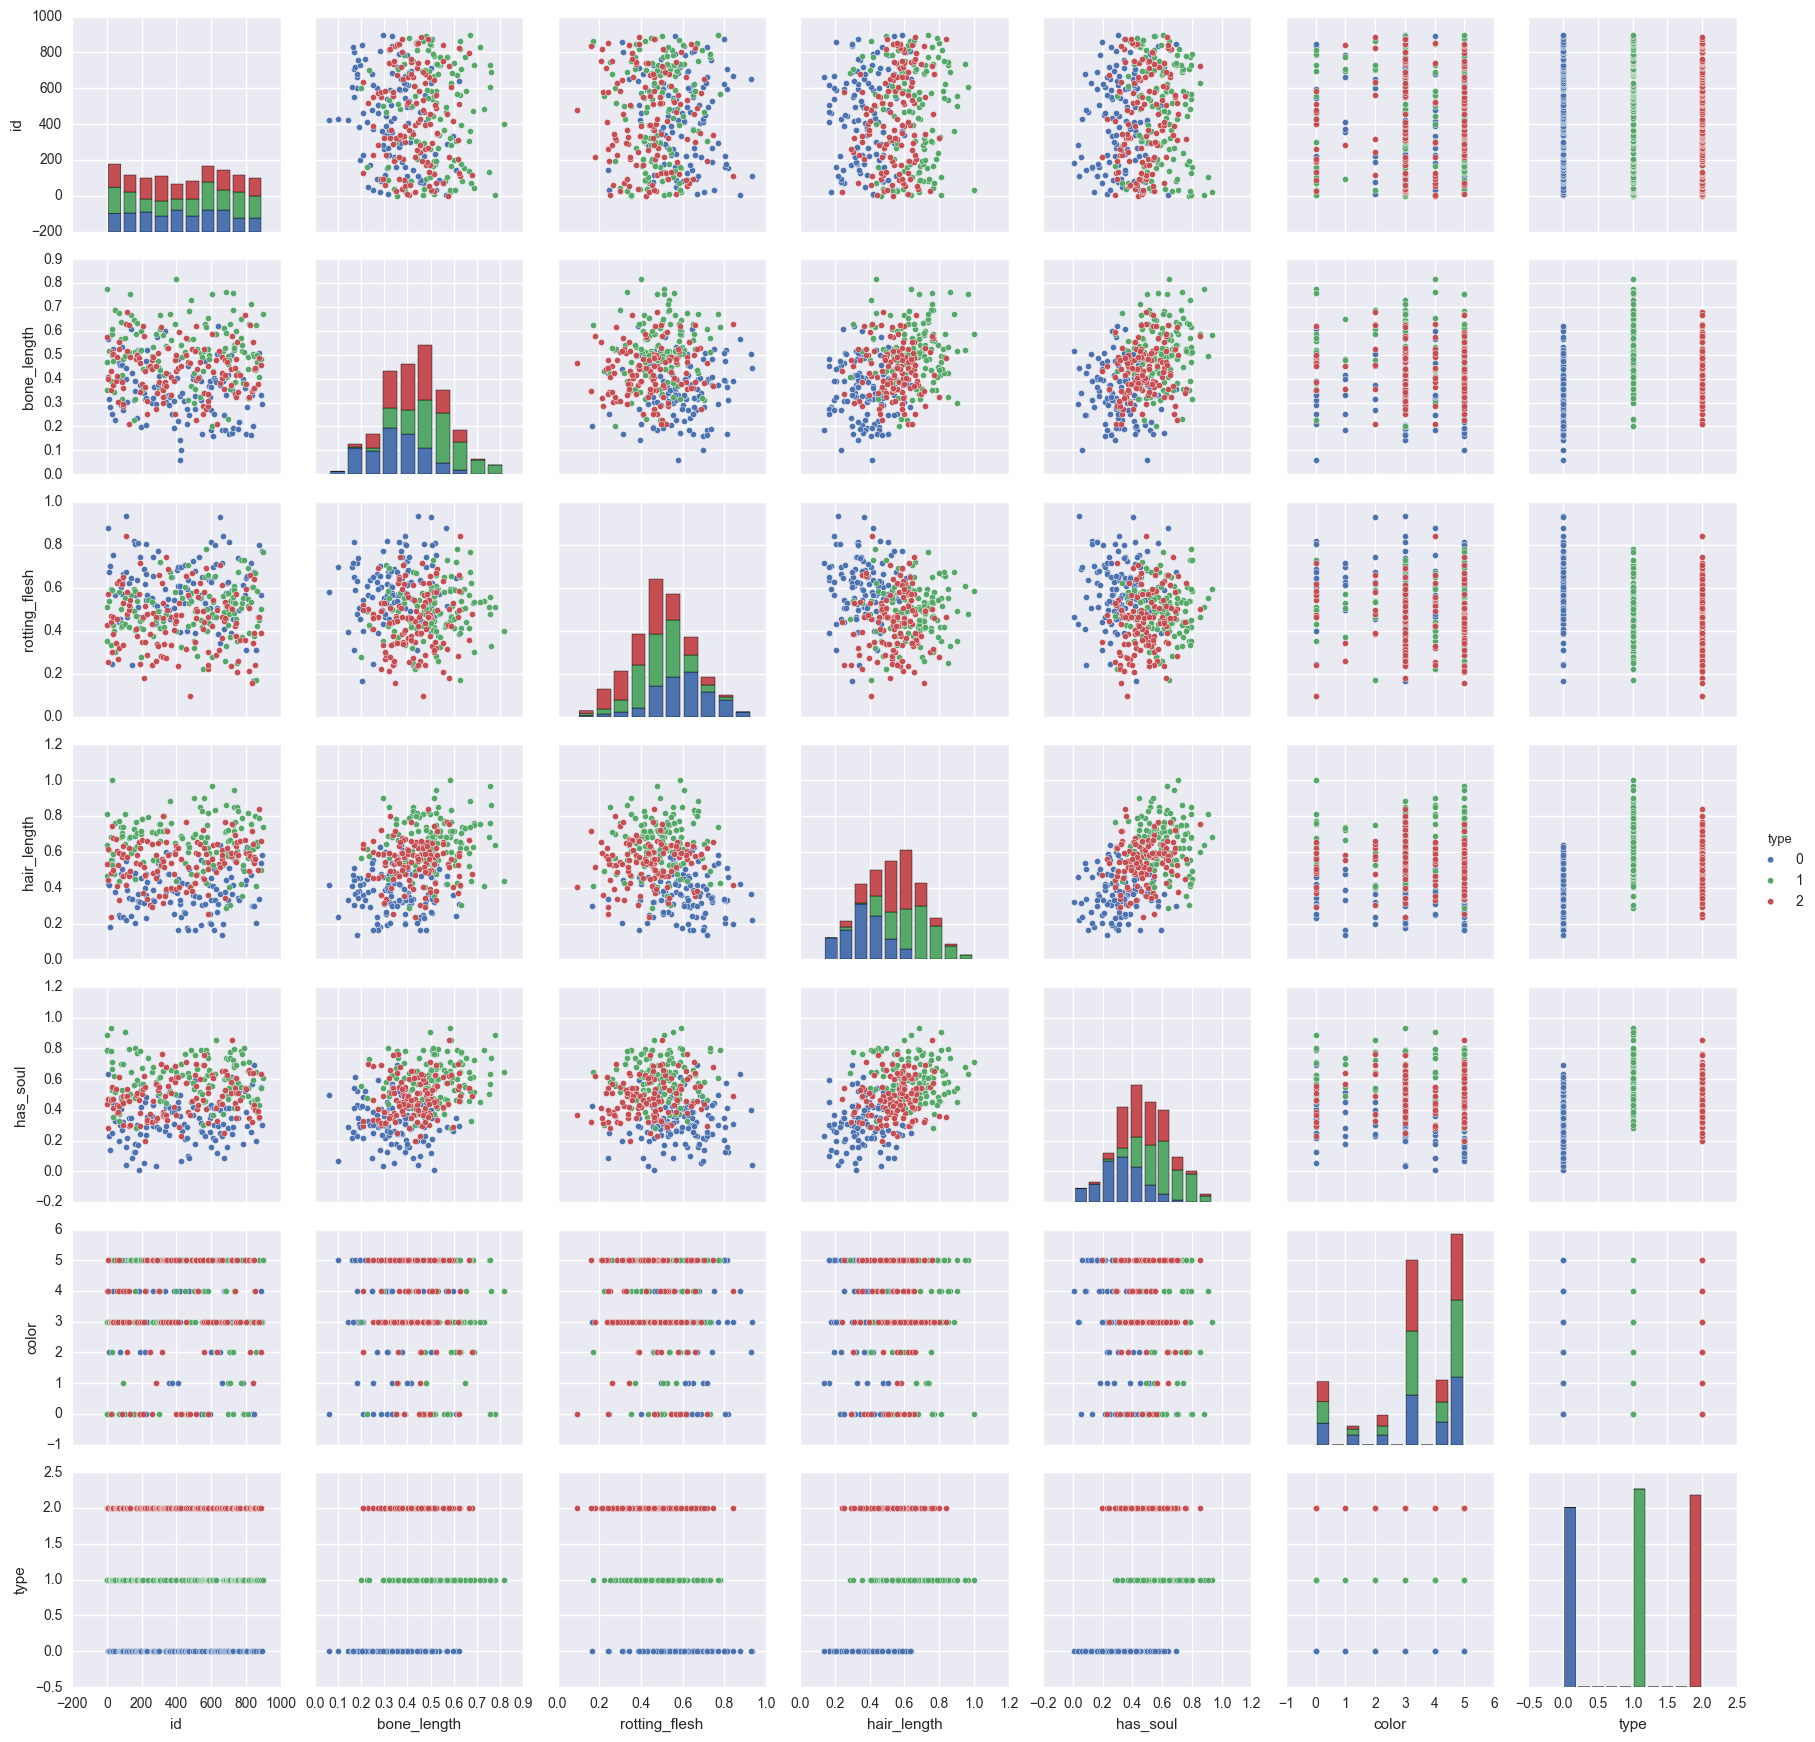

In [48]:
## 1.特征选择：观察每个特征跟target情况
import seaborn as sns
%matplotlib inline
sns.pairplot(monster, hue='type')

In [32]:
def create_features(dataframe):
    #Create some new variables.
    dataframe['hair_soul'] = dataframe['hair_length'] * dataframe['has_soul']
    dataframe['bone_soul'] = dataframe['bone_length'] * dataframe['has_soul']
    dataframe['hair_bone'] = dataframe['hair_length'] * dataframe['bone_length']
    dataframe['rotting_hair'] = dataframe['rotting_flesh'] * dataframe['hair_length']
    dataframe['rotting_soul'] = dataframe['rotting_flesh'] * dataframe['has_soul']
create_features(monster)

feature_names = ["bone_length", "rotting_flesh", "hair_length", "has_soul", "color", "hair_soul","bone_soul", "hair_bone", "rotting_hair", "rotting_soul",]

X = monster[feature_names]
y = np.asarray(monster[['type']], dtype="|S6")

## 2. 特征选择：随机森林中 feature_importance

feature_importance = FeatureSelect(X, y, feature_names)
print feature_importance
feature_select = []
for i in feature_importance:
    if i[0] > 0.03:
        feature_select.append(i[1])
print feature_select
#print monster['type']

[(0.2091, 'hair_bone'), (0.1919, 'hair_soul'), (0.1114, 'bone_soul'), (0.1105, 'hair_length'), (0.1003, 'rotting_flesh'), (0.0728, 'rotting_hair'), (0.0702, 'has_soul'), (0.0612, 'rotting_soul'), (0.052, 'bone_length'), (0.0206, 'color')]
['hair_bone', 'hair_soul', 'bone_soul', 'hair_length', 'rotting_flesh', 'rotting_hair', 'has_soul', 'rotting_soul', 'bone_length']


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [33]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn import metrics

clfs = [
        RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=300, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=300, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)
       ]

stacker = LogisticRegression()
n_folds = 10

X = monster[feature_select]
y = np.asarray(monster[['type']], dtype="|S6")

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.1) 

en = Ensemble(n_folds, clfs, stacker)

print("Starting to train ensemble model...")
y_test_predict = en.fit_predict(train_X, train_y, test_X)
print("Ended to train ensemble model...")

score = metrics.accuracy_score(test_y, y_test_predict)
print score

Starting to train ensemble model...


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Ended to train ensemble model...
0.789473684211


In [42]:
# 导入测试集文件
monster_test = pd.read_csv("../input/test.csv")

# 特征数值化，注意测试集不含'type'列，所以只对'color'执行即可
color_list = monster_test.color.unique()

# 对测试集做预测
create_features(monster_test)
predictions = en.predict(monster_test[feature_select])
#print predictions.asarray(int)
# 生成包含结果的DataFrame对象
submission = pd.DataFrame({
    "id": monster_test["id"],
    "type": predictions
})
#print submission['type'].dtype
submission['type'] = type_label.inverse_transform(submission['type'].astype(int))

# 在计算过程中我们将'type'做了数值化，而比赛的评分系统只认原始的字符串，所以需要反向还原为字符

#print submission
submission.to_csv("result.csv", index=False)

f = open("result.csv")
#print(f.read())